### Lisa Fung, Testing CMTF-OPT1, TensorLy CMTF-ALS, SystemsSerologyCMTF, 2023.01.21 - 2023.02.03
Running tests of speed and accuracy of my optimized CMTF versus TensorLy CMTF-ALS on Synthetic Data

**TensorLy CMTF-ALS**

In [1]:
from tensorly.decomposition._cmtf_als import coupled_matrix_tensor_3d_factorization as cmtf_als

**Optimized CMTF (v1)**

In [2]:
from optimized_cmtf_v1 import *

**Systems Serology CMTF**
- Initially ran into "ValueError: Removal of missing values has eliminated all data."
    - Due to PCA imputation from `statsmodels`: https://github.com/statsmodels/statsmodels/blob/main/statsmodels/multivariate/pca.py
    - FIX: removed PCA imputation (filling in missing values) from code

In [3]:
from systems_serology_tensor import *

Measuring Tensor reconstruction error, Wall time of CMTF on Synthetic Data

**Arguments used:**
- Rank = `np.arange(3, 31)`
- Max iterations = 100 (default)
    - Systems Serology default is 2000 iterations, so tested on 2000 iter and 100 iter
- Tolerance = 10e-6 (default)

**Procedure:**
- Perform 5 trials for each set of parameters (size, rank) on CMTF
- Plot the averages of those 5 runs for each measurement

**Details:**
- Tensor and matrix reconstruction error computed with RMSE using following formula (as in S3CMTF):
$\sqrt{\frac{1}{|\Omega_{test}|} \sum_{\forall \alpha \in \Omega_{test}} (x_\alpha - \tilde{x}_\alpha)^2}$
    - In TensorLy, we can use: `RMSE(tensor, tl.cp_to_tensor(cptensor))`
    - Accounts of both matrix and tensor (errors added)
- Wall time is computed only for CMTF function itself. (Wall time is considered a more accurate measurement of running time than CPU time)
- Storing values in `numpy.array` instead of Python list because retrieval is much faster

In [4]:
import numpy as np
import tensorly as tl
from tensorly import random
from tensorly.decomposition import CP, parafac
from tensorly.metrics.regression import RMSE
import time

def test_cmtf(cmtf, I, ranks, num_trials):
    """Tests the speed and accuracy of CMTF function on I x I x I tensors for I in sizes.
    Parameters
    ----------
    cmtf : function
        CMTF function to run (`cmtf_opt1` or `cmtf_als`)
    I : int
        Dimension measurement to generate I x I x I tensors
    ranks : np.array
        List of ranks to test cmtf on for size I
    num_trials : int
        Number of trials per rank to run for size I

    Returns
    -------
    cpfactors : 2D np.array with (weights, factors) as entries
        List Weights and factors of CMTF function from cmtf for different sizes I
    runtimes : 2D np.array
        List of runtimes per rank per trial for I
    recon_errors : 2D np.array
        List of last reconstruction errors (last element of errors returned from tensorly.decomposition.parafac) 
        for different sizes I
    """
    
    # initialize measurements
    
    tensor_list = np.zeros((len(ranks), num_trials), dtype=object)
    matrix_list = np.zeros((len(ranks), num_trials), dtype=object)
    tensor_factors = np.zeros((len(ranks), num_trials), dtype=object) # A
    matrix_factors = np.zeros((len(ranks), num_trials), dtype=object) # V
    runtimes = np.zeros((len(ranks), num_trials+1)) # last column is for averages
    recon_errors = np.zeros((len(ranks), num_trials+1)) # last column is for averages

    # loop through ranks and num_trials
    
    for r in range(len(ranks)):
        for n in range(num_trials):
            
            tensor_list[r][n] = random.random_tensor((I, I, I)) # create tensor of size I x I x I with random values
            matrix_list[r][n] = random.random_tensor((I, I)) # create tensor of size I x I x I with random values

            start_time = time.time() # start time of function, wall time

            ## Run CMTF function (for dense tensors)
            
            # TensorLy CMTF-ALS
            if (cmtf == cmtf_als):
                tensor_factors[r][n], matrix_factors[r][n], errors = cmtf_als(tensor_list[r][n], matrix_list[r][n], ranks[r])
            
            # My CMTF_OPT1
            if (cmtf == cmtf_opt1): 
                tensor_factors[r][n], matrix_factors[r][n] = cmtf_opt1(tensor_list[r][n], matrix_list[r][n], ranks[r])
            
            # Systems Serology CMTF
            if (cmtf == perform_CMTF):
                result = perform_CMTF(tOrig=tensor_list[r][n], mOrig=matrix_list[r][n], r=ranks[r])
                tensor_factors[r][n] = result
                matrix_factors[r][n] = CPTensor((None, [result.factors[0], result.mFactor]))

            runtimes[r][n] = time.time() - start_time # total time taken for function, wall time

            recon_errors[r][n] = RMSE(tensor_list[r][n], tl.cp_to_tensor(tensor_factors[r][n])) + RMSE(matrix_list[r][n], tl.cp_to_tensor(matrix_factors[r][n])) # store RMSE error measurement
            
        # take average of runtime and recon_error measurements
        runtimes[r][num_trials] = np.mean(runtimes[r][0:num_trials])
        recon_errors[r][num_trials] = np.mean(recon_errors[r][0:num_trials])
        
    return tensor_list, matrix_list, tensor_factors, matrix_factors, runtimes, recon_errors
            

def run_test_cmtf(cmtf):
    """Run test of cmtf (ALS, OPT, System) and store results."""
    
    sizes = [10, 25, 50] # array of sizes I to test
    ranks = np.arange(3, 31) # ranks to test
    num_trials = 5
    
    # initialize np arrays to store measurements
    tensor_list_all = np.zeros((len(sizes), len(ranks), num_trials), dtype=object)
    matrix_list_all = np.zeros((len(sizes), len(ranks), num_trials), dtype=object)
    tensor_factors_all = np.zeros((len(sizes), len(ranks), num_trials), dtype=object)
    matrix_factors_all = np.zeros((len(sizes), len(ranks), num_trials), dtype=object)
    runtimes_all = np.zeros((len(sizes), len(ranks), num_trials+1))
    recon_errors_all = np.zeros((len(sizes), len(ranks), num_trials+1))
    
    for s in range(len(sizes)):
        tensor_list_all[s], matrix_list_all[s], tensor_factors_all[s], matrix_factors_all[s], runtimes_all[s], recon_errors_all[s] = test_cmtf(cmtf, sizes[s], ranks, num_trials) 
        # 5 trials for each combination of size and rank
            
    return tensor_list_all, matrix_list_all, tensor_factors_all, matrix_factors_all, runtimes_all, recon_errors_all
    

**Collecting and Saving Data**

In [4]:
# Collect data for CMTF-ALS, DONE

#tensor_list_als, matrix_list_als, tensor_factors_als, matrix_factors_als, runtimes_als, recon_errors_als = run_test_cmtf(cmtf_als)

In [15]:
# Collect data for CMTF-OPT-1, DONE

#tensor_list_opt1, matrix_list_opt1, tensor_factors_opt1, matrix_factors_opt1, runtimes_opt1, recon_errors_opt1 = run_test_cmtf(cmtf_opt1)

In [11]:
# Collect data for Systems Serology CMTF, DONE 2000 iter and 100 iter

#tensor_list_ss, matrix_list_ss, tensor_factors_ss, matrix_factors_ss, runtimes_ss, recon_errors_ss = run_test_cmtf(perform_CMTF)

In [6]:
# Save data

sizes = [10, 25, 50] # array of sizes I

for s in range(len(sizes)):
    
    # saving tensor_list and cpfactor causes errors because entries are not numbers, so code removed
    
    # cmtf_als: Already saved successfully on 1/21/23, saved again on 1/31/23
    #np.savetxt('tensorly_cmtf_als_runtime_list_size_{}.csv'.format(sizes[s]), runtimes_als[s], delimiter=',')
    #np.savetxt('tensorly_cmtf_als_error_list_size_{}.csv'.format(sizes[s]), recon_errors_als[s], delimiter=',')
    
    # cmtf_opt1: saved successfully on 1/31/23
    #np.savetxt('cmtf_opt1_runtime_list_size_{}.csv'.format(sizes[s]), runtimes_opt1[s], delimiter=',')
    #np.savetxt('cmtf_opt1_error_list_size_{}.csv'.format(sizes[s]), recon_errors_opt1[s], delimiter=',')
    
    # perform_CMTF (SS): saved successfully on 2/2/23 (2000 iter), saved 2/3/23 (100 iter)
    #np.savetxt('tensorly_cmtf_ss_runtime_list_size_{}.csv'.format(sizes[s]), runtimes_ss[s], delimiter=',')
    #np.savetxt('tensorly_cmtf_ss_error_list_size_{}.csv'.format(sizes[s]), recon_errors_ss[s], delimiter=',')

**Importing Data**

In [1]:
import numpy as np

sizes = [10, 25, 50] # array of sizes I
ranks = np.arange(3, 31) # ranks
num_trials = 5

runtimes_als = np.zeros((len(sizes), len(ranks), num_trials+1))
recon_errors_als = np.zeros((len(sizes), len(ranks), num_trials+1))
runtimes_opt1 = np.zeros((len(sizes), len(ranks), num_trials+1))
recon_errors_opt1 = np.zeros((len(sizes), len(ranks), num_trials+1))
    
for s in range(len(sizes)):
    runtimes_als[s] = np.loadtxt('tensorly_cmtf_als_runtime_list_size_{}.csv'.format(sizes[s]), delimiter=',')
    recon_errors_als[s] = np.loadtxt('tensorly_cmtf_als_error_list_size_{}.csv'.format(sizes[s]), delimiter=',')
    
    runtimes_opt1[s] = np.loadtxt('cmtf_opt1_runtime_list_size_{}.csv'.format(sizes[s]), delimiter=',')
    recon_errors_opt1[s] = np.loadtxt('cmtf_opt1_error_list_size_{}.csv'.format(sizes[s]), delimiter=',')

In [2]:
recon_errors_opt1.shape

(3, 28, 6)

**Plotting TensorLy parafac data**

Plot of runtime vs rank for sizes I = 10, 25, 50

Plot of recon_errors vs rank for sizes I = 10, 25, 50

**Plots for TensorLy's CMTF-ALS**

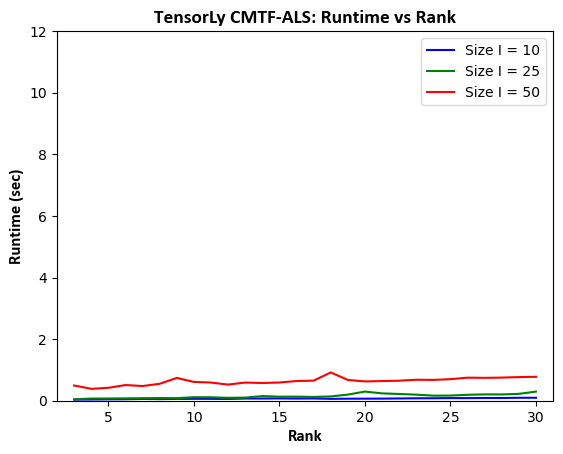

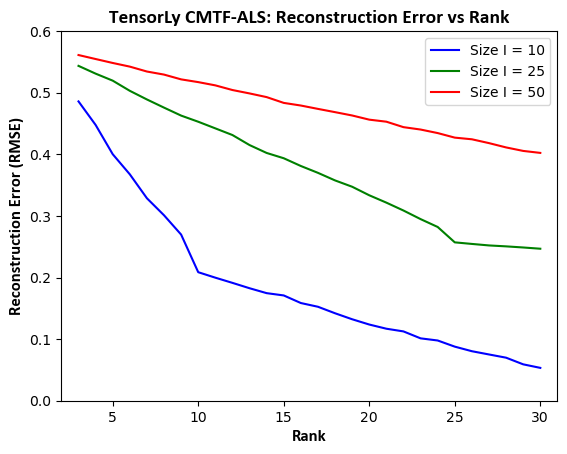

In [8]:
import numpy as np
import matplotlib.pyplot as plt

sizes = [10, 25, 50] # array of sizes I
ranks = np.arange(3, 31) # ranks
num_trials = 5


# Plot 1: TensorLy CMTF-ALS: Runtime vs Rank

plt.figure()
plt.plot(ranks, runtimes_als[0,:,5],'b-', ranks, runtimes_als[1,:,5],'g-', 
         ranks, runtimes_als[2,:,5],'r-')
plt.title('TensorLy CMTF-ALS: Runtime vs Rank', fontname="Calibri", size=14, weight='bold')
plt.xlabel('Rank', fontname="Calibri", size=12, weight='bold')
plt.ylabel('Runtime (sec)', fontname="Calibri", size=12, weight='bold')
plt.xlim(ranks[0] - 1, ranks[-1] + 1)
plt.ylim(0, 12)
plt.legend( ['Size I = 10', 'Size I = 25', 'Size I = 50'] )
#plt.savefig('final_bold_tensorly_cmtf_als_runtime_plot.png', dpi=1200) # Saved

# Plot 2: TensorLy CMTF-ALS: Reconstruction Error vs Rank

plt.figure()
plt.plot(ranks, recon_errors_als[0,:,5],'b-', ranks, recon_errors_als[1,:,5],'g-', 
         ranks, recon_errors_als[2,:,5],'r-')
plt.title('TensorLy CMTF-ALS: Reconstruction Error vs Rank', fontname="Calibri", size=14, weight='bold')
plt.xlabel('Rank', fontname="Calibri", size=12, weight='bold')
plt.ylabel('Reconstruction Error (RMSE)', fontname="Calibri", size=12, weight='bold')
plt.xlim(ranks[0] - 1, ranks[-1] + 1)
plt.ylim(0, 0.6)
plt.legend( ['Size I = 10', 'Size I = 25', 'Size I = 50'] )
#plt.savefig('final_bold_tensorly_cmtf_als_error_plot.png', dpi=1200) # Saved

**Plots for my CMTF_OPT1**

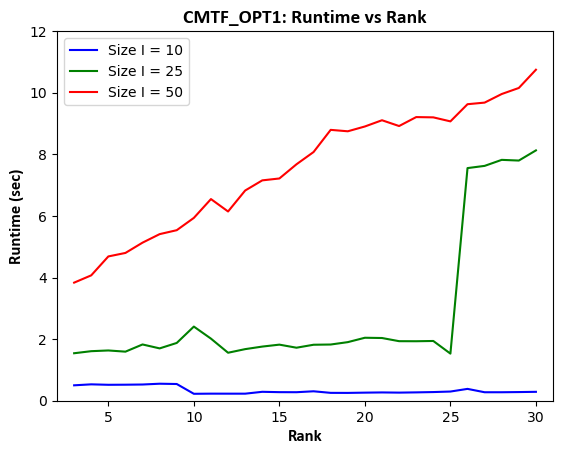

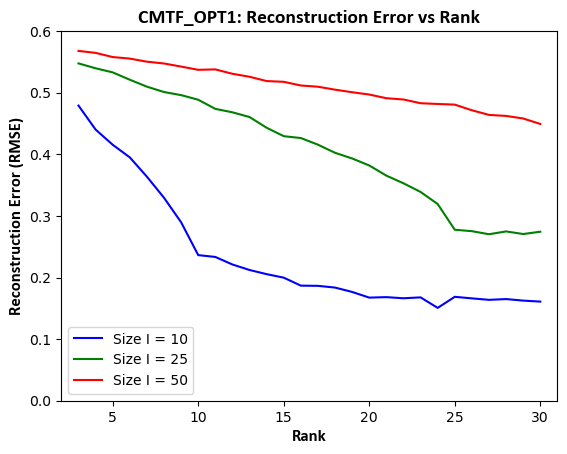

In [9]:
# Setup

import numpy as np
import matplotlib.pyplot as plt

sizes = [10, 25, 50] # array of sizes I
ranks = np.arange(3, 31) # ranks
num_trials = 5


# Plot 1: CMTF_OPT1: Runtime vs Rank

plt.figure()
plt.plot(ranks, runtimes_opt1[0,:,5],'b-', ranks, runtimes_opt1[1,:,5],'g-', 
         ranks, runtimes_opt1[2,:,5],'r-')
plt.title('CMTF_OPT1: Runtime vs Rank', fontname="Calibri", size=14, weight='bold')
plt.xlabel('Rank', fontname="Calibri", size=12, weight='bold')
plt.ylabel('Runtime (sec)', fontname="Calibri", size=12, weight='bold')
plt.xlim(ranks[0] - 1, ranks[-1] + 1)
plt.ylim(0, 12)
plt.legend( ['Size I = 10', 'Size I = 25', 'Size I = 50'] )
#plt.savefig('final_bold_cmtf_opt1_runtime_plot.png', dpi=1200) # Saved

# Plot 2: CMTF_OPT1: Tensor Reconstruction Error vs Rank

plt.figure()
plt.plot(ranks, recon_errors_opt1[0,:,5],'b-', ranks, recon_errors_opt1[1,:,5],'g-', 
         ranks, recon_errors_opt1[2,:,5],'r-')
plt.title('CMTF_OPT1: Reconstruction Error vs Rank', fontname="Calibri", size=14, weight='bold')
plt.xlabel('Rank', fontname="Calibri", size=12, weight='bold')
plt.ylabel('Reconstruction Error (RMSE)', fontname="Calibri", size=12, weight='bold')
plt.xlim(ranks[0] - 1, ranks[-1] + 1)
plt.ylim(0, 0.6)
plt.legend( ['Size I = 10', 'Size I = 25', 'Size I = 50'] )
#plt.savefig('final_bold_cmtf_opt1_error_plot.png', dpi=1200) # Saved

**Plots for Systems Serology CMTF**

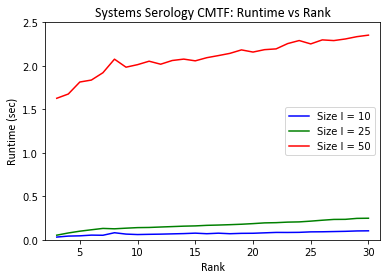

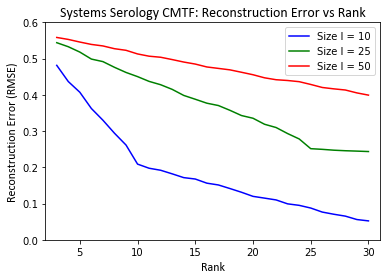

In [9]:
import numpy as np
import matplotlib.pyplot as plt

sizes = [10, 25, 50] # array of sizes I
ranks = np.arange(3, 31) # ranks
num_trials = 5


# Plot 1: Systems Serology CMTF: Runtime vs Rank

plt.figure()
plt.plot(ranks, runtimes_ss[0,:,5],'b-', ranks, runtimes_ss[1,:,5],'g-', 
         ranks, runtimes_ss[2,:,5],'r-')
plt.title('Systems Serology CMTF: Runtime vs Rank', fontname="Calibri", size=14)
plt.xlabel('Rank', fontname="Calibri", size=12)
plt.ylabel('Runtime (sec)', fontname="Calibri", size=12)
plt.xlim(ranks[0] - 1, ranks[-1] + 1)
plt.ylim(0, 2.5)
plt.legend( ['Size I = 10', 'Size I = 25', 'Size I = 50'] )
#plt.savefig('systems_serology_cmtf_100_iter_runtime_plot.png', dpi=1200) # Saved 2000 iter, 100 iter

# Plot 2: Systems Serology CMTF: Reconstruction Error vs Rank

plt.figure()
plt.plot(ranks, recon_errors_ss[0,:,5],'b-', ranks, recon_errors_ss[1,:,5],'g-', 
         ranks, recon_errors_ss[2,:,5],'r-')
plt.title('Systems Serology CMTF: Reconstruction Error vs Rank', fontname="Calibri", size=14)
plt.xlabel('Rank', fontname="Calibri", size=12)
plt.ylabel('Reconstruction Error (RMSE)', fontname="Calibri", size=12)
plt.xlim(ranks[0] - 1, ranks[-1] + 1)
plt.ylim(0, 0.6)
plt.legend( ['Size I = 10', 'Size I = 25', 'Size I = 50'] )
#plt.savefig('systems_serology_cmtf_100_iter_error_plot.png', dpi=1200) # Saved 2000 iter, 100 iter